## Classificatin by using Convolutional Neural Networks
Convolutional Neural Networks are a specialized type of deep neural network, inspired by the organization of the animal visual cortex. They are designed to automatically and adaptively learn spatial hierarchies of features from input images. CNNs excel at capturing intricate patterns and structures within images, making them indispensable in various computer vision applications.

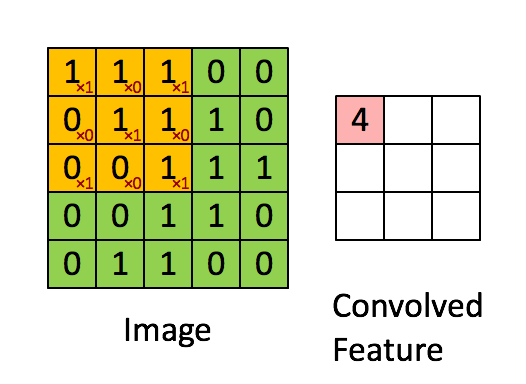

## CNN Architecturte
A Convolutional Neural Network (CNN) architecture is a deep learning model designed to automatically learn and extract hierarchical patterns from input data, particularly images. Through a series of convolutional, pooling, and fully connected layers, CNNs capture spatial features, enabling tasks like image classification, object detection, and segmentation.

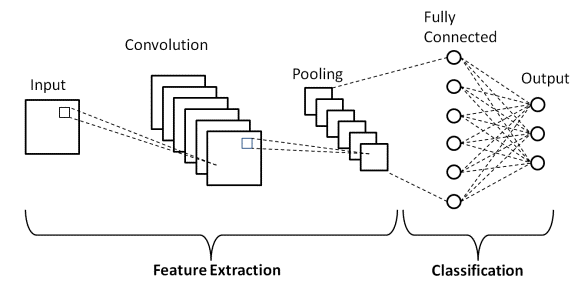

## Importing libraries
1. `import torch`: This imports the main PyTorch library, which provides support for tensor computations and building neural networks.

2. `import torch.nn as nn`: This imports the `nn` module from PyTorch, which includes pre-defined neural network layers, activation functions, loss functions, and more. It's used for defining the architecture of neural networks.

3. `import torch.optim as optim`: This imports the `optim` module from PyTorch, which contains optimization algorithms such as SGD, Adam. These optimizers are used to update the parameters of neural networks during training to minimize the loss function.

4. `import torchvision`: This imports the torchvision library, which provides common datasets, pre-trained models, and image transformations for computer vision tasks.

5. `import torchvision.transforms as transforms`: This imports the `transforms` module from torchvision, which contains various image transformations like resizing, cropping, and normalization. These transformations are applied to input images before feeding them into neural networks for training or inference.
Certainly!

6. `import matplotlib.pyplot as plt`: This imports the `pyplot` module from Matplotlib, enabling the creation of various plots and visualizations. It's commonly used for data visualization, including images and other types of data.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1000)

## Loading MNIST Dataset

1. **Transforms Definition**: A `Compose` object from `transforms` is created to chain together transformations. In this case, `ToTensor()` converts PIL images to tensors, and `Normalize()` normalizes pixel values of the image tensors to have a mean and standard deviation of 0.5.

2. **Training Dataset Loading**: The `MNIST` dataset is loaded for training (`train=True`). If the dataset is not already downloaded, it will be downloaded to the specified root directory (`'./data'`). The defined transforms are applied to each image in the dataset. The resulting dataset is stored in `trainset`.

3. **Training DataLoader Creation**: The `DataLoader` is created using `trainset`, specifying a batch size of 32 for efficient minibatch training. The `shuffle=True` argument ensures that the data is shuffled randomly during each epoch of training.

4. **Testing Dataset Loading**: Similar to the training dataset loading, the MNIST dataset is loaded for testing (`train=False`). Again, if the dataset is not already downloaded, it will be downloaded to the specified root directory (`'./data'`). The same transforms as used for training are applied.

5. **Testing DataLoader Creation**: The `DataLoader` is created for the testing dataset (`testset`). It also specifies a batch size of 32 but with `shuffle=False`, as there is no need to shuffle the data during testing.

In [2]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 89800813.53it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99373005.60it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31926227.82it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19844300.80it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



We can get a look at some of the images within our dataset to see what we're working with. The function below plots a square grid of images. If you supply less than a complete square number of images it will ignore the last few.

In [3]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

Let's load 25 images. These will have been processed through our transforms, so will be randomly rotated and cropped.

It's a good practice to see your data with your transforms applied, so you can ensure they look sensible. For example, it wouldn't make sense to flip the digits horizontally or vertically unless you are expecting to see what in your test data.

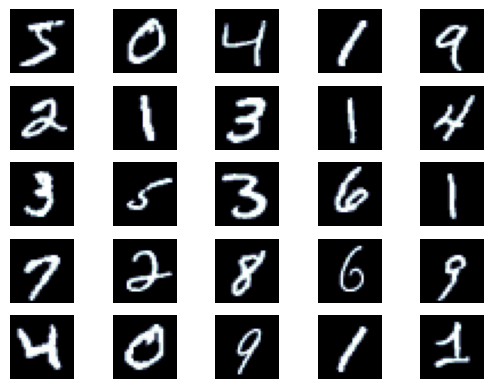

In [4]:
N_IMAGES = 25

images = [image for image, label in [trainset[i] for i in range(N_IMAGES)]]

plot_images(images)

We can print out the number of examples again to check our splits are correct.

In [5]:
print(f'Number of training examples: {len(trainset)}')
print(f'Number of testing examples: {len(testset)}')

Number of training examples: 60000
Number of testing examples: 10000


### CNN MOdel

1. **Initialization (`__init__`)**:
   - In the `__init__` method, the constructor initializes the layers of the CNN model.
   - `self.conv1`: This is the first convolutional layer. It takes an input image with 1 channel (grayscale) and applies 32 filters (output channels) with a kernel size of 3x3 and padding of 1.
   - `self.conv2`: This is the second convolutional layer. It takes the output of the first convolutional layer (which has 32 channels) and applies 64 filters with the same kernel size and padding.
   - `self.pool`: This is a max-pooling layer with a kernel size of 2x2 and a stride of 2. It reduces the spatial dimensions of the input by half.
   - `self.fc1`: This is the first fully connected (dense) layer. It takes the output of the second convolutional layer (after flattening it using `view`) and applies 128 neurons.
   - `self.fc2`: This is the second fully connected layer, which outputs 10 neurons corresponding to the 10 classes in the MNIST dataset.

2. **Forward Pass (`forward`)**:
   - The `forward` method defines the forward pass of the model.
   - `x = self.pool(torch.relu(self.conv1(x)))`: Applies the first convolutional layer, followed by ReLU activation, and then max-pooling.
   - `x = self.pool(torch.relu(self.conv2(x)))`: Applies the second convolutional layer, followed by ReLU activation, and then max-pooling.
   - `x = x.view(-1, 64 * 7 * 7)`: Flattens the output from the convolutional layers into a 1D tensor.
   - `x = torch.relu(self.fc1(x))`: Applies the first fully connected layer followed by ReLU activation.
   - `x = self.fc2(x)`: Applies the second fully connected layer without activation, as it will be handled by the loss function during training.

In [6]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Model Initialization

1. **Instantiate the Model (`model = CNN()`)**:
   - This line creates an instance of the `CNN` class, which was defined earlier. The `CNN` class represents your convolutional neural network architecture.

2. **Define the Loss Function (`criterion = nn.CrossEntropyLoss()`)**:
   - Here, you're defining the loss function to be used during training. `nn.CrossEntropyLoss()` is a common choice for classification tasks like the MNIST dataset. It combines softmax activation and cross-entropy loss into a single class. It expects raw logits (output of the last layer of the neural network) and class labels as inputs.

3. **Define the Optimizer (`optimizer = optim.Adam(model.parameters(), lr=0.001)`)**:
   - This line defines the optimizer, which is responsible for updating the parameters (weights and biases) of the neural network during training to minimize the loss.
   - `optim.Adam()` is one of the optimization algorithms provided by PyTorch. It's a variant of stochastic gradient descent (SGD) that adapts the learning rate for each parameter, allowing for faster convergence.
   - `model.parameters()` provides the parameters (weights and biases) of the `model` instance (i.e., the CNN model) that need to be optimized.
   - `lr=0.001` sets the learning rate, which determines the step size for parameter updates during optimization. A learning rate of 0.001 is commonly used as a starting point for many deep learning tasks, but it can be adjusted based on the specific problem and network architecture.


In [7]:
# Instantiate the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training
1. **Setting Up Training Parameters**:
   - `epochs`: This variable defines the number of times the entire dataset will be passed forward and backward through the neural network. Each pass of the entire dataset is called an epoch.
   - `losses = []`: This list will be used to store the average loss computed over mini-batches during training. It's useful for tracking the model's performance over time.

2. **Training Loop**:
   - The outer loop iterates over the specified number of epochs, ensuring that the model sees the entire dataset multiple times.
   - Inside the epoch loop, `running_loss` is initialized to 0.0. This variable will accumulate the loss across mini-batches within each epoch.
   - The inner loop iterates over the mini-batches of the training data (`trainloader`).
   - `optimizer.zero_grad()`: Clears the gradients of all optimized parameters before the backward pass.
   - `outputs = model(inputs)`: Forward pass: computes the output predictions (`outputs`) for the current mini-batch.
   - `loss = criterion(outputs, labels)`: Computes the loss between the predicted outputs and the actual labels using the defined loss function (`criterion`).
   - `loss.backward()`: Backward pass: Computes the gradient of the loss with respect to the model parameters.
   - `optimizer.step()`: Updates the model parameters based on the computed gradients and the optimization algorithm.
   - `running_loss += loss.item()`: Accumulates the loss for the current mini-batch.
   - Every 1000 mini-batches (`if i % 1000 == 999`), the average loss over these mini-batches is printed and appended to the `losses` list.
   - After completing an epoch, the training loop moves to the next epoch until all epochs are completed.

3. **Completion of Training**:
   - Once all epochs are completed, the message `'Finished Training'` is printed, indicating that the training process has finished.



In [8]:
# Train the model
epochs = 5
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:  # Print every 1000 mini-batches
            print('epoch: %d loss: %.3f' %
                  (epoch + 1, running_loss / 1000))
            losses.append(running_loss / 1000)
            running_loss = 0.0

print('Finished Training')

epoch: 1 loss: 0.191
epoch: 2 loss: 0.042
epoch: 3 loss: 0.028
epoch: 4 loss: 0.022
epoch: 5 loss: 0.015
Finished Training


## ploting the loss curve

- `plt.plot(losses)`: This function plots the values stored in the `losses` list. The x-axis represents the number of iterations (or mini-batches) during training, while the y-axis represents the corresponding loss values.
- The plotted curve provides insight into how the loss decreases over time as the model learns from the training data. A decreasing loss indicates that the model is improving its performance, while fluctuations or increases may suggest issues with training convergence or overfitting.


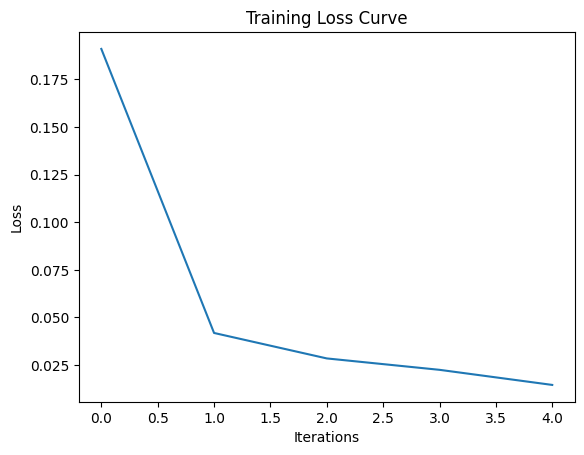

In [9]:
# Plot the loss curve
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

## Testing the Model

1. **Initialization**:
   - `correct = 0`: Initializes a variable to count the number of correctly predicted labels.
   - `total = 0`: Initializes a variable to count the total number of samples in the test dataset.

2. **Evaluation Loop**:
   - `with torch.no_grad():`: This context manager ensures that no gradients are computed during the evaluation, which saves memory and computation.
   - The loop iterates over the test dataset (`testloader`) one mini-batch at a time.
   - For each mini-batch, `inputs` contains a batch of test images, and `labels` contains the corresponding ground truth labels.
   - `outputs = model(inputs)`: Computes the predicted outputs for the test images using the trained model.
   - `_, predicted = torch.max(outputs.data, 1)`: Finds the index of the maximum value in each output vector, effectively predicting the class label for each image.
   - `total += labels.size(0)`: Increments the total count by the number of samples in the current mini-batch.
   - `correct += (predicted == labels).sum().item()`: Compares the predicted labels with the ground truth labels and sums up the number of correct predictions. The `.item()` method is used to convert the result to a Python scalar.
   
3. **Accuracy Calculation**:
   - After evaluating all mini-batches in the test dataset, the accuracy is calculated as the ratio of correctly predicted samples to the total number of samples in the test dataset.
   - The accuracy is then printed as a percentage.


In [10]:
# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test images: %d %%' % (100 * correct / total))

Accuracy on the test images: 99 %
